**Disclaimer**: This notebook is based on the one by [Thomas Wiecki](https://twitter.com/twiecki) & [Ravin Kumar](https://twitter.com/canyon289) which can be found [here](https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/supply_chain.ipynb).

In [1]:
%matplotlib inline

import pymc3 as pm
import theano.tensor as tt
import pandas as pd
import numpy as np
from scipy import optimize
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '..')

import utils.utils as u
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

# Bayes for supply chain optimization

#### The business case
Supply chain optimization is the typical business problem that people who don't own a business never think about. However, it's ubiquitous to small and large businesses and spans virtually all those sectors where goods are exchanged.

The business problem arises from the fact that storing items in e.g. a wharehouse (the so called "inventory") before they get sold costs money. You don't want to store too many of them. At the same time, you don't want to store too few of them because then you miss out on some profit. You want to store the optimum amount of items to maximise your profits. The problem of supply chain optimization can be summarized by the quesiton:

> *What is the optimum number of items to store in inventory for maximizing profit?*

This question can be answered with "classical methods" that use point estimates for the quantities of interest, or with a Bayesian approach that incorporares uncertainties in the quantities of interest. We will look at both approaches in the following sections.

#### The toy problem

You are the owner of a succesful Italian wine company. Over the years, you have built strong relationships with 2 farmers that supply the grapes for the wine. Furthermore, you recently started buying grapes from a third farmer that uses innovative methods in his vineyards. Not all the grapes you buy from a farmer are of good quality: some don't pass your rigorous quality checks and must be discarded. The percentage of grapes that passes the quality check is the `yield`. 

The grapes from different suppliers have different `yield`s, different `price`s, and different maximum amount that can be provided. You know the current price and maximum amount for each supplier, but you don't know the true yield of this year. However, you have access to past data about it.

In [2]:
PRICES = [220.0, 100.0, 120.0] # euros per ton
MAX_ORDER_SIZE = [100, 80, 100] # in tons
past_yield = u.make_yield_data()
past_yield

[array([0.978235  , 0.98946102, 0.99035051, 0.83762708, 0.66130327,
        0.98785994, 0.85327018, 0.8500779 , 0.99913878, 0.89881072,
        0.8175994 , 0.95181804, 0.91545214, 0.87137954, 0.96166603,
        0.99033823, 0.96319861, 0.94124979, 0.96555922, 0.96606356,
        0.92723444, 0.97736913, 0.86764773, 0.81749131, 0.98597604,
        0.97980665, 0.77295709, 0.9584931 , 0.88875261, 0.99585613]),
 array([0.51788973, 0.67831661, 0.64888304, 0.61595363, 0.08634205,
        0.72543455, 0.51883833, 0.5454235 , 0.30357696, 0.21743938,
        0.54628383, 0.68559965, 0.28827533, 0.79246239, 0.65810975,
        0.69059483, 0.59297579, 0.85482231, 0.38115298, 0.8296909 ]),
 array([0.89241857, 0.9000698 ])]

Since you started working with the third supplier very recently, there is `yield` info only for the past two years. Let's visualize the data:

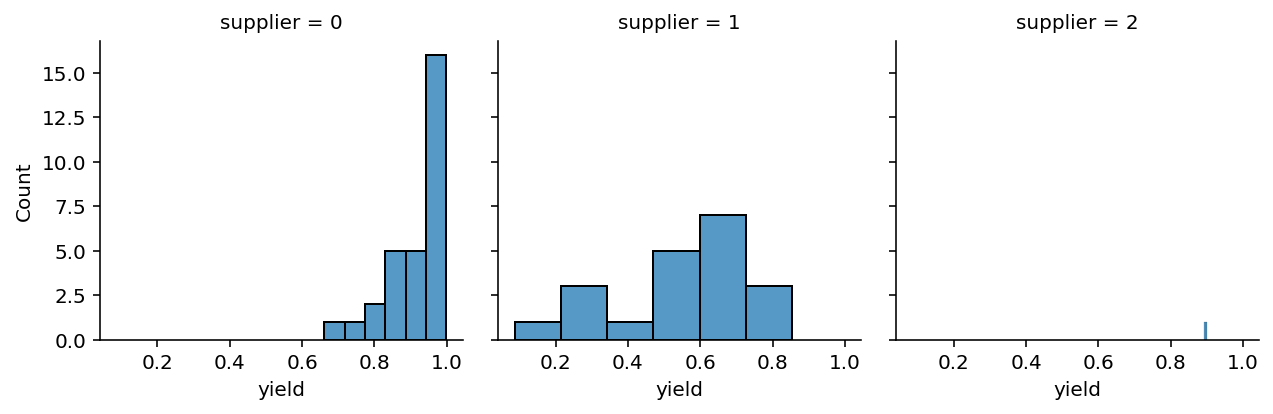

In [3]:
data_df = pd.DataFrame(past_yield).T
data_tidy = data_df.unstack().to_frame('yield')
data_tidy.index = data_tidy.index.set_names(['supplier', 'obs'])
g = sns.FacetGrid(data=data_tidy.reset_index().dropna(), col='supplier')
g.map(sns.histplot, 'yield', kde=False);

These are the suppliers' data. Some of it is known with certainty (`PRICE`, `MAX_ORDER_SIZE`), some is not (`yield`) and must be estimated from past data. 

On the other hand of the supply chain there are your customers. In order to know how many tons of grapes you should buy from your suppliers, you must first know how many bottles of wine your customers will buy. This is the realm of *demand forecasting*, a whole topic on its own. There are very complex models to determine the future `demand` for a certain product but, in this case, we will estimate it from past data just like for `yield`.

**Note**: To simplify things we assume that you sell packages of 100 bottles of wine and that, to make 100 bottles of wines you need 1 ton of grapes.

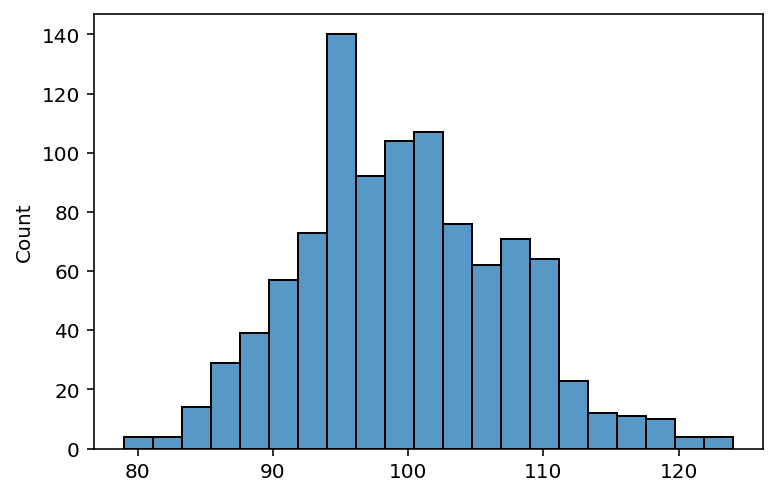

In [4]:
past_demand = u.make_demand_data()
sns.histplot(past_demand);

As mentioned at the beginning, the whole problem of supply chain optimization lies in the fact that storing the wine has a cost. If you buy too many kilos of grapes and produce too much wine your `HOLDING_COST` will grow and eat out your profits. On the other hand, if you buy too few kilos, you won't be able to produce enough wine and will miss out on profits. For your wine company you have:

In [5]:
SALES_PRICE = 500 #euros per package of 100 bottles
HOLDING_COST = 100 #euros per package of 100 bottles

The aim of supply chain optimization is to order the right amount of grapes from each of our suppliers to maximize/minimize a certain quantity. This quantity is usually related to money, but it can really be anything we want to optimize for. We specify the quantity you want to optimize through a `loss` function. In our case, the loss function takes as inputs the tons of grapes in our stock, how many packages of wine customers want, at what price we bought the grapes, at what price we can sell the wine, and what the holding costs are:

In [6]:
@np.vectorize
def loss(in_stock, demand, buy_price, sales_price=SALES_PRICE, holding_cost=HOLDING_COST):
    # How much do we earn per 100 bottles
    margin = sales_price - buy_price
    # Do we have more in stock than demanded?
    if in_stock > demand:
        total_profit = demand * margin
        # everything left over after demand was met goes into holding
        total_holding_cost = (in_stock - demand) * holding_cost
        reward = total_profit - total_holding_cost
    else:
        # Can only sell what we have in stock, no storage required
        reward = in_stock * margin
    
    # Usually we minimize, so invert
    return -reward

For example, let's assumethe price at which we buy the grapes from one of our suppliers is $75$ €/ton and the demand is $50$ packages. We can then compute the profit we would make for different values of the packages in our stock.

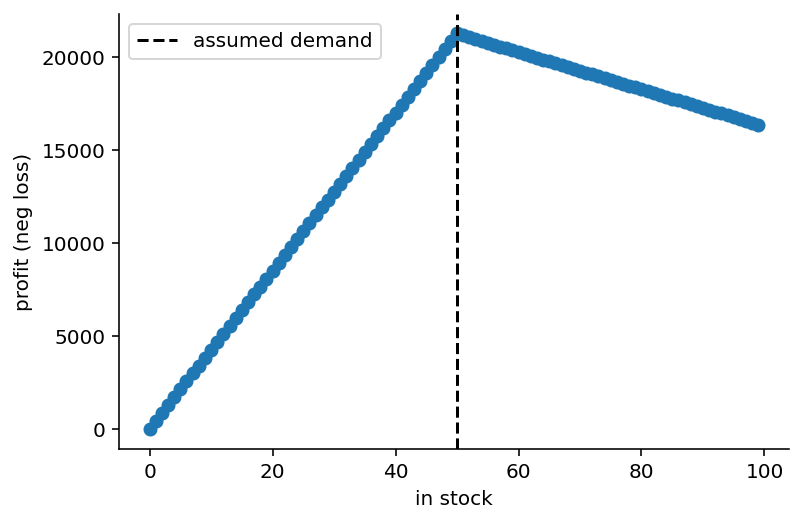

In [7]:
in_stock = np.arange(0, 100)
demand = 50
buy_price = 75

plt.scatter(in_stock, -loss(in_stock, demand=demand, buy_price=buy_price))
plt.axvline(demand, c='k', ls='--', label='assumed demand')
plt.xlabel('in stock')
plt.ylabel('profit (neg loss)') 
sns.despine()
plt.legend();

As obvious, if the total client demand is 50 packages, your profit would be maximized if you have exactly 50 packages in stock. If you have 51, the additional package that does not get sold is going to reduce your profits. If you havee 49, you will miss out on profits.

In a similar manner, we can fix the number of packages `in_stock` to, say, $100$ and see how our profit varies based on different `demand`s.

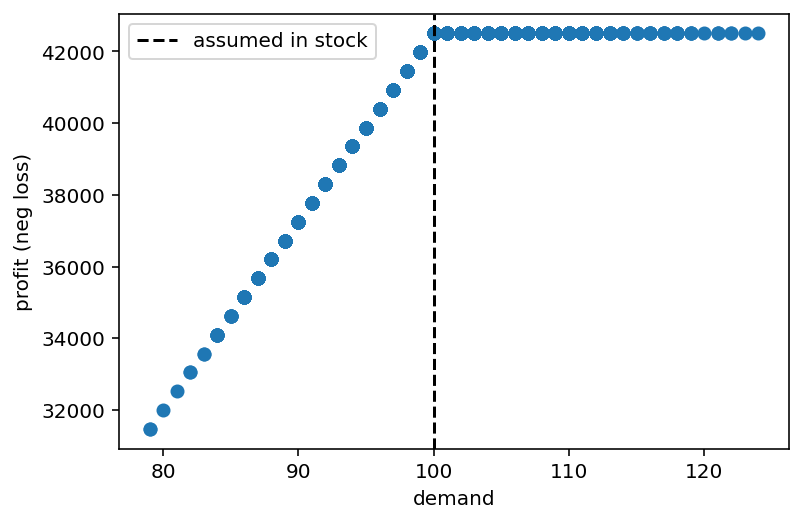

In [8]:
in_stock = 100
buy_price = 75
plt.scatter(past_demand, -loss(in_stock=in_stock, demand=past_demand, buy_price=buy_price))
plt.xlabel('demand')
plt.ylabel('profit (neg loss)') 
plt.axvline(in_stock, c='k', ls='--', label='assumed in stock');
plt.legend();

In response to demand, the loss-function behaves differently: with less demand than what we have in stock, we earn less (because we sell fewer packages of wine but also have to pay holding costs), but as demand exceeds the number of packages we have in stock our profit stays flat because we can't sell more than what we have.

The `loss` function is often a custom function that should reflect the dynamics and priorities of the business. It is often beneficial spending some time crafting a good loss function since the outcome of the optimization procedure will be heavily dependent on it.

## Estimating yield with a Bayesian model

Bayesian modeling can be used to estimate the quantities we are unsure about, namely `yield` and `demand`. Let's look at `tield` for now. We treat these quantities as *random variables* and assign them a probability distribution.

Bayesian modeling can be tackled in 3 steps:
1. **Select a generative model for the data**: you must specify a statistical model that may have plausibly generated the data. We observe that `yield` is a continuous quantity that varies between $0$ and $1$. For these quantities a beta probability distribution is approriate. Furthermore, we assume for simplicity the yield of this year is purely due to chance, i.e. to *aleatoric uncertainty*, and therefore it is not a function of any other quanity (e.g. the temperature, the current economic conditions, etc). Hence:

$$\texttt{yield}=\epsilon\sim Beta(\alpha,\beta).$$

The values of $a$ and $b$ are unkown to us and we want to find them out. These are the (hyper-)parameters of our model, which we express as $\theta=[\alpha,\beta]$. Bayes' theorem can be formulated as:

$$p(\theta|\texttt{past\_yield}) \propto (\texttt{past\_yield}|\theta)p(\theta),$$

where `past_yield` are the observed data.

2. **Choose a prior for your parameters**: $\alpha$ and $\beta$ must be positive [by construction](https://en.wikipedia.org/wiki/Beta_distribution), therefore we select an half-normal distribution for them and add a small number to it to make sure they are always positive.

$$\alpha \sim HalfNormal(0, 10^2), \;\;\; \beta\sim HalfNormal(0, 10^2).$$


3. **Approximate the posterior** using a probabilistic programming library. Let's use [`PyMC3`](http://pymc.io) for this.

In [9]:
with pm.Model() as model:
    # Priors on alpha and beta parameters for each of the 3 suppliers
    n_suppliers = 3
    α = pm.HalfNormal('α', sd=10., shape=n_suppliers) + 1
    β = pm.HalfNormal('β', sd=10., shape=n_suppliers) + 1
    
    # Different likelihood for every supplier because we have different
    # number of data points
    for i, d in enumerate(past_yield):
        pm.Beta(f'supplier_yield_obs_{i}', alpha=α[i], beta=β[i],  observed=d)
    
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


/Users/zbelligoli/opt/anaconda3/envs/bayes_4_business/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


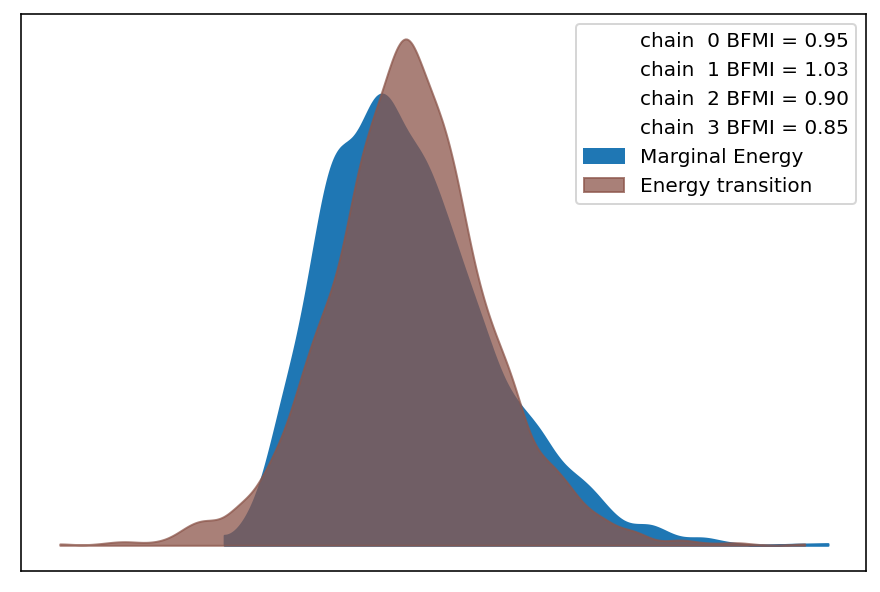

In [10]:
# make sure convergence looks good, i.e. when the marginal energy distribution and 
# the energy transition density display good overlap.
# See page 45 of https://arxiv.org/pdf/1701.02434.pdf
az.plot_energy(trace);

Now we have an updated (i.e. informed by the past data about the `yield`) posterior distribution for $\alpha$ and $\beta$ which, in turns, give us information about the distribution of `yield`.

## Generate possible future scenarios

In order to perform Bayesian Decision Making we need an estimate of what the future might look like. As we are in a generative framework this is trivial: we just need to sample from the [posterior predictive distribution](https://en.wikipedia.org/wiki/Posterior_predictive_distribution) of our model which generates new data based on our estimated posteriors. Let's thereofre generate 1000 samples from the posterior distirbution to see what `yield` we can expect for this harvest.

In [11]:
with model:
    post_pred = pm.sample_posterior_predictive(trace, 1000)

/Users/zbelligoli/opt/anaconda3/envs/bayes_4_business/lib/python3.8/site-packages/pymc3/sampling.py:1707: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


/Users/zbelligoli/opt/anaconda3/envs/bayes_4_business/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


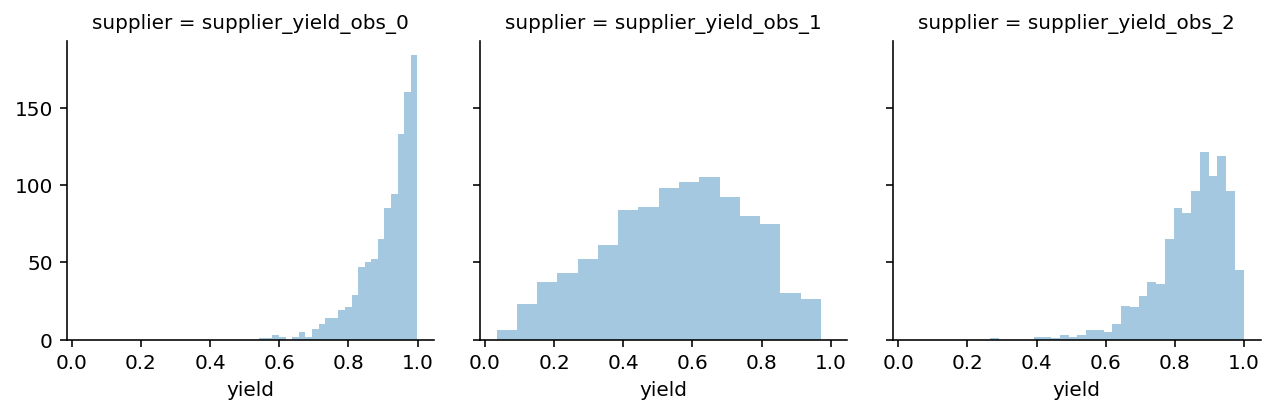

In [12]:
supplier_yield_post_pred = pd.DataFrame({k: v[:, 1] for k, v in post_pred.items()})
data_tidy = supplier_yield_post_pred.unstack().to_frame('yield')
data_tidy.index = data_tidy.index.set_names(['supplier', 'obs'])
g = sns.FacetGrid(data=data_tidy.reset_index().dropna(), col='supplier')
g.map(sns.distplot, 'yield', kde=False);

This plot shows, given the data and our model, what we can expect to observe. Note that these predictions take the uncertainty into account (as opposed to "classical methods" using only point estimates). For supplier 2 we have a lot of uncertainty because we only observed very few data points.

Given these estimates we can write a function that converts the orders we place to each supplier, the yield we assume for each one, and what their prices are.

In [13]:
def calc_yield_and_price(orders, 
                         supplier_yield=np.array([.9, .5, .8]),
                         prices=PRICES
                        ):
    orders = np.asarray(orders)
    
    full_yield = np.sum(supplier_yield * orders)
    price_per_item = np.sum(orders * prices) / np.sum(orders)
    
    return full_yield, price_per_item

calc_yield_and_price([100, 60, 60])

(168.0, 160.0)

So given these (randomly picked) order amounts to each supplier and some deterministic yield, we would receive 168 tons of grapes at an effective price of 160 euros per ton.

## Bayesian Decision Making

Now we have to actually do the optimization. First, we need to specify our objective function which will compute the total yield and effective price given a posterior predictive sample. Once we have that and our demand (also a sample from that distribution), we can compute our loss. As we have a distribution over possible scenarios, we compute the loss for each one and return the distribution.

In [14]:
def objective(orders, 
              supplier_yield=supplier_yield_post_pred,
              demand_samples=past_demand, 
              max_order_size=MAX_ORDER_SIZE
              ):
    orders = np.asarray(orders)
    losses = []
    
    # Negative orders are impossible, indicated by np.inf
    if np.any(orders < 0):
        return np.inf
    # Ordering more than the supplier can ship is also impossible
    if np.any(orders > MAX_ORDER_SIZE):
        return np.inf
    
    # Iterate over post pred samples provided in supplier_yield
    for i, supplier_yield_sample in supplier_yield.iterrows():
        full_yield, price_per_item = calc_yield_and_price(
            orders,
            supplier_yield=supplier_yield_sample
        )
        
        # evaluate loss over each sample with one sample from the demand distribution
        loss_i = loss(full_yield, past_demand[i], price_per_item)
        
        losses.append(loss_i)
        
    return np.asarray(losses)

Great, we have all our required functions, let's put things into an optimizer and see what happens.

In [15]:
# parameters for the optimization, we're just including the max order sizes as bounds
bounds = [(0, max_order) for max_order in MAX_ORDER_SIZE]
starting_value = [50., 50., 50.]

In [16]:
# minimize the expected loss under all possible scenarios
opt_stoch = optimize.minimize(lambda *args: np.mean(objective(*args)), 
                              starting_value, 
                              bounds=bounds)

In [17]:
print('Optimal order amount from every supplier = {}'.format(np.ceil(opt_stoch.x)))

Optimal order amount from every supplier = [  0.  46. 100.]


In [18]:
print('Total order amount from all suppliers = {}'.format(np.ceil(np.sum(opt_stoch.x))))

Total order amount from all suppliers = 145.0


Great, we did it! Excitedly you go to your manager and tell her the amazing model you built and the **optimal order amounts**. Unfortunately, she is not impressed and asks "that's some fancy technique, but I'm not convinced this is actually better than what we currently use which is to just take the means of the yield distribution for each supplier."

## Evaluation

Slightly discouraged you go back to your desk and wonder why life is so unfair and you actually have to prove that things work and why "but it's Bayesian!" is not as convincing an argument as you hoped for. After some deep reflection you come to the conclusion that your manager might have a point and that additional complexity must be warranted and demonstrably better. To build a more compelling case, you decide to compare the naive method of just using the means to your fancy method in terms of expected profit in a simulation study.

Instead of samples from the posterior predictive, we can just pass a single sample -- the mean -- into our objective function.

In [37]:
supplier_yield_mean = pd.DataFrame([np.mean(d) for d in past_yield]).T
supplier_yield_mean

,0,1,2
0,0.918735,0.558903,0.896244


As well as the demand we expect on average. This way we can still use the above objective function but the loop will just run once. 

In [42]:
opt_non_stoch = optimize.minimize(lambda *args: objective(*args, 
                                                          supplier_yield=supplier_yield_mean, 
                                                          demand_samples=past_demand.mean()), 
                                  starting_value, 
                                  bounds=bounds)

In [43]:
print('Optimal order amount from every supplier = {}'.format(np.ceil(opt_non_stoch.x)))

Optimal order amount from every supplier = [40. 45. 40.]


In [44]:
print('Total order amount from all suppliers = {}'.format(np.ceil(np.sum(opt_non_stoch.x))))

Total order amount from all suppliers = 123.0


The results are certainly different. The full Bayesian treatment seems to dislike our high-cost but high-quality supplier. It also orders more in total (probably to account for the lower yield of the other two suppliers). But which one is actually better in terms of our profit?

To answer that question, we will generate new data from our true generative model and compute the profit in each new scenario given the order amounts from the two optimizations. In practice, the true generative model of the data is unknown. one can therefore generate random data and compute what the expected profit will be.

In [45]:
data_new = u.make_yield_data(n_obs=[1000, 1000, 1000], seed=np.random.seed(123))
data_new = pd.DataFrame(data_new).T
data_new.head().add_prefix("Supplier ")

,Supplier 0,Supplier 1,Supplier 2
0,0.973547,0.801664,0.948694
1,0.981153,0.305007,0.862389
2,0.799606,0.284151,0.648398
3,0.875838,0.328614,0.966406
4,0.934080,0.199405,0.832561


/Users/zbelligoli/opt/anaconda3/envs/bayes_4_business/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


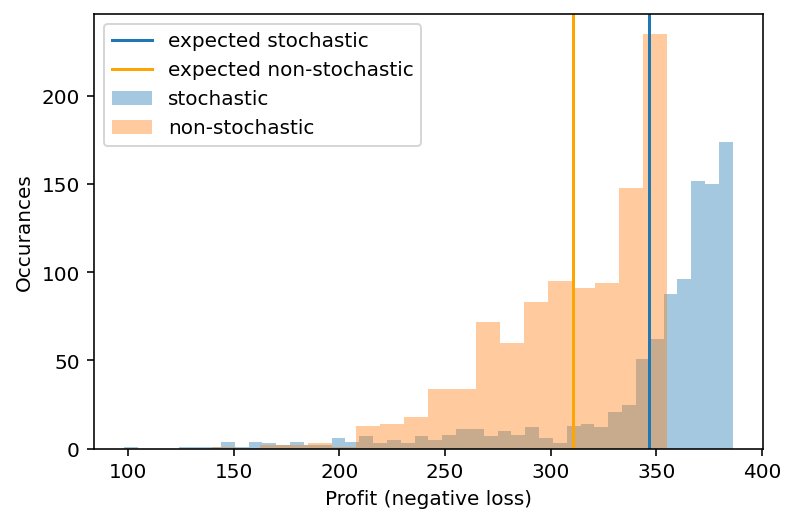

In [46]:
neg_loss_stoch = -objective(opt_stoch.x, supplier_yield=data_new) / past_demand
neg_loss_non_stoch = -objective(opt_non_stoch.x, supplier_yield=data_new) / past_demand
sns.distplot(neg_loss_stoch, label='stochastic', kde=False)
plt.axvline(np.mean(neg_loss_stoch), label='expected stochastic')
sns.distplot(neg_loss_non_stoch, label='non-stochastic', kde=False)
plt.axvline(np.mean(neg_loss_non_stoch), color='orange', label='expected non-stochastic')
plt.legend(); plt.xlabel('Profit (negative loss)'); plt.ylabel('Occurances');

In [47]:
print('Expected profit of Bayesian model = %.2f BTC' % np.mean(neg_loss_stoch))
print('Expected profit of naive model = %.2f BTC' % np.mean(neg_loss_non_stoch))
print('Expected value of including uncertainty = %.2f BTC' % (np.mean(neg_loss_stoch) - np.mean(neg_loss_non_stoch)))

Expected profit of Bayesian model = 346.71 BTC
Expected profit of naive model = 310.68 BTC
Expected value of including uncertainty = 36.04 BTC


Your manager is very pleased that you finally speak her language and demonstrated an expected 10% increase in profit, which translates to millions of additional profit over a year at the scale your wine company operates on.

## Useful resources and links:
- [Bayesian Decision Theory Made Ridiculously Simple](http://www.statsathome.com/2017/10/12/bayesian-decision-theory-made-ridiculously-simple/)